In [1]:
# Convert to slides
#jupyter nbconvert ceo_request.ipynb --to slides --post serve \
#--no-prompt \
#--TagRemovePreprocessor.remove_input_tags=remove_input \
#--TagRemovePreprocessor.remove_all_outputs_tags=remove_output

In [2]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from olist.seller import Seller
from olist.data import Olist
from olist.order import Order
%config InlineBackend.figure_format = 'svg'
%load_ext autoreload
%autoreload 2

Get all the data we need :

In [3]:
matching_table = Olist().get_matching_table()
orders = Order().get_training_data()
sellers = Seller().get_training_data()
sellers['sales_per_order'] = sellers['sales'] / sellers['n_orders']
sorted_sellers = sellers.sort_values(by='profits', ascending=False)

# The Next Olist

<img src='https://storage.googleapis.com/kaggle-datasets-images/78342/179673/4051e8a3f3a6562f956b80977db4dcd1/data-original.png?t=2018-11-16-16-45-14'/>

## Objectives

- Increase customer satisfaction

- Increase profit margin

- Maintain a healthy order volume

# Conclusion

## Profits to aim for


- olist can aim to improve by **60% its benefits**


- How ? By removing known **underperforming sellers** and track new ones

# Underperforming sellers

In [5]:
def benefits_of_removing(n, df):
    """return the sum of the column 'profits' of the df
    with the last n rows removed, in %gain of original profits"""
    original_profit = df[['profits']].sum()['profits']
    new_df = df[['profits']].copy()
    new_df.drop(new_df.tail(n).index,inplace=True)
    return (new_df.sum()['profits'] - original_profit)/original_profit*100

dico_profits = {
    'n_sellers_removed': [i for i in range(sorted_sellers.shape[0])],
    'benefits_of_removing': [benefits_of_removing(n=i, df=sorted_sellers) \
      for i in range(sorted_sellers.shape[0])]
}
profits_df = pd.DataFrame(dico_profits)

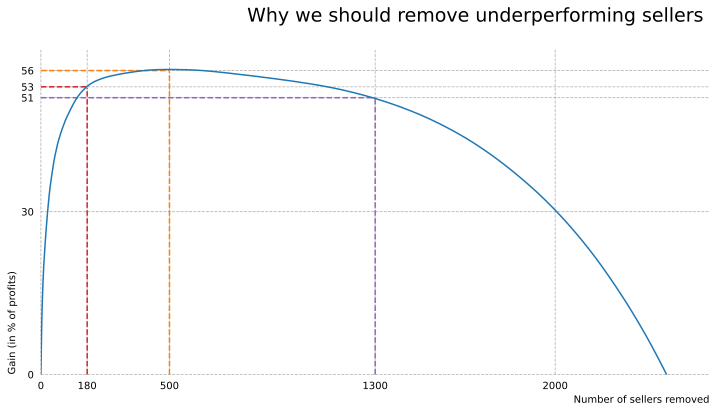

In [47]:
n_worst_sellers = 180
n_bad_sellers = 500
n_neutral_sellers = 1300
list_x_ticks = [n_worst_sellers, n_bad_sellers, n_neutral_sellers]
list_y_ticks = [53, 56, 51]
plt.figure(figsize=(12,6))
ax = sns.lineplot(
    x='n_sellers_removed',
    y='benefits_of_removing',
    data=profits_df,
    color='tab:blue'
)
plt.axvline(list_x_ticks[0], 0, 0.88, color='tab:red', linestyle='--')
plt.hlines(list_y_ticks[0], 0, n_worst_sellers, color='tab:red', linestyle='--')
plt.axvline(list_x_ticks[1], 0, 0.93, color='tab:orange', linestyle='--')
plt.hlines(list_y_ticks[1], 0, n_bad_sellers, color='tab:orange', linestyle='--')
plt.axvline(list_x_ticks[2], 0, 0.85, color='tab:purple', linestyle='--')
plt.hlines(list_y_ticks[2], 0, n_neutral_sellers, color='tab:purple', linestyle='--')

ax.set_xticks([0, 2000]+ list_x_ticks)
ax.set_yticks([0, 30] + list_y_ticks)
ax.set_xlabel('Number of sellers removed', loc='right')
ax.set_ylabel('Gain (in % of profits)', loc='bottom')
plt.title(
    label='Why we should remove underperforming sellers \n',
    loc='right',
    fontdict={
        'fontsize': 19,
        'fontweight': 7,
        'color': 'black',
    }
)
sns.despine(left=True, bottom=True)
plt.tick_params(bottom=False, left=False)
ax.grid(axis='both', ls='--')
ax.set(ylim=(0,60), xlim=(0, 2600));

## Sellers profiles


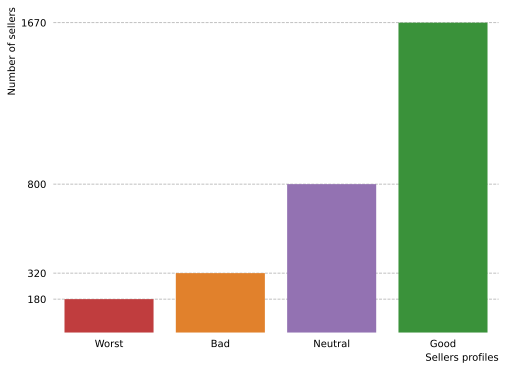

In [48]:
sellers_profiles = pd.DataFrame({
    'profiles':['Worst', 'Bad', 'Neutral', 'Good'],
    'number':[180, 320, 800, 1670]})
plt.figure(figsize=(8,6))
ax = sns.barplot(data=sellers_profiles,
            x='profiles', y='number',
           palette={
               'Worst': 'tab:red',
               'Bad': 'tab:orange',
               'Neutral': 'tab:purple',
               'Good': 'tab:green'
           })
ax.set_axisbelow(True)
sns.despine(left=True, bottom=True)
ax.grid(axis='y', ls='--')
plt.tick_params(bottom=False, left=False)
ax.set_yticks(list(sellers_profiles['number']))
ax.set_xlabel('Sellers profiles', loc='right')
ax.set_ylabel('Number of sellers', loc='top');

# Know your ennemies
<img src='https://imgr.cineserie.com/2020/09/brouillon-auto-8.jpg?imgeng=/f_jpg/cmpr_0/w_660/h_370/m_cropbox&ver=1' />

Create a dataframe for each seller profile :

In [34]:
worst_sellers = sorted_sellers.iloc[-n_worst_sellers:].copy()
bad_sellers = sorted_sellers.iloc[-n_bad_sellers:].copy()
neutral_sellers = sorted_sellers.iloc[-n_neutral_sellers:].copy()
good_sellers = sorted_sellers.iloc[:(sorted_sellers.shape[0]-n_neutral_sellers)].copy()

#Create a 'profile' column in the original df, to categorize each seller
seg_sellers = sorted_sellers.copy()
n_sellers = seg_sellers.shape[0]
seg_sellers['profile'] = 'Worst'
seg_sellers.loc[
    seg_sellers.head(n_sellers - n_worst_sellers).index,'profile'] = 'Bad'
seg_sellers.loc[
    seg_sellers.head(n_sellers - n_bad_sellers).index,'profile'] = 'Neutral'
seg_sellers.loc[
    seg_sellers.head(n_sellers - n_neutral_sellers).index,'profile'] = 'Good'

## Old or new friends ?

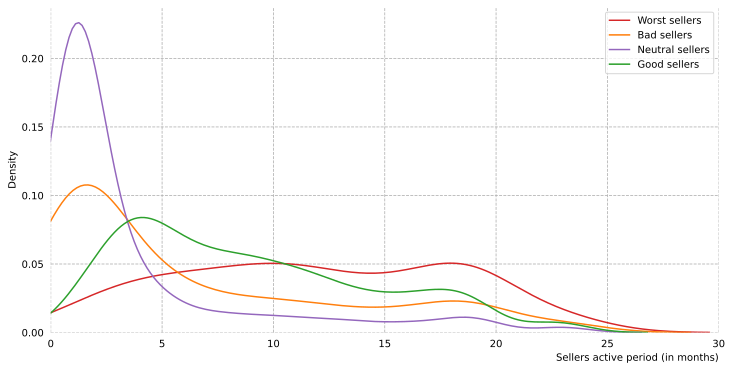

In [49]:
plt.figure(figsize=(12,6))
feature = 'active_months'
ax = sns.kdeplot(worst_sellers[feature],label='Worst sellers', color='tab:red')
sns.kdeplot(bad_sellers[feature], label='Bad sellers', color='tab:orange')
sns.kdeplot(neutral_sellers[feature], label='Neutral sellers', color='tab:purple')
sns.kdeplot(good_sellers[feature], label='Good sellers', color='tab:green')
ax.set(xlim=(0, 30))
ax.set_axisbelow(True)
sns.despine(left=True, bottom=True)
plt.tick_params(bottom=False, left=False)
ax.grid(axis='both', ls='--')
ax.set_xlabel('Sellers active period (in months)', loc='right');
plt.legend();

## Slow delivery ?

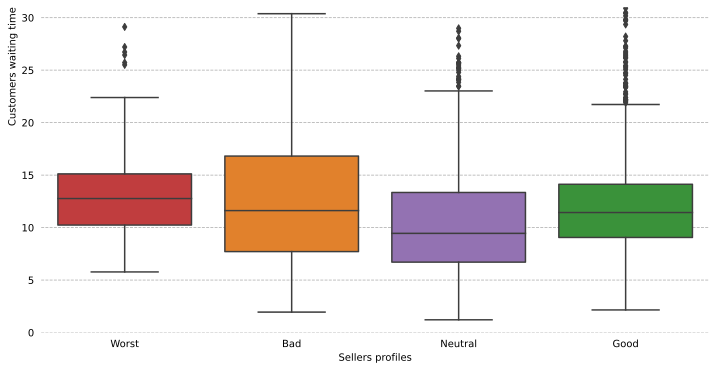

In [52]:
plt.figure(figsize=(12,6))
feature = 'wait_time'
ax = sns.boxplot(
    y=feature,
    x='profile',
    data=seg_sellers,
    order=["Worst", "Bad", 'Neutral', 'Good'],
    palette={
               'Worst': 'tab:red',
               'Bad': 'tab:orange',
               'Neutral': 'tab:purple',
               'Good': 'tab:green'
           }
)
ax.set_axisbelow(True)
ax.set_ylabel('Customers waiting time', loc='top')
ax.set_xlabel('Sellers profiles')
sns.despine(left=True, bottom=True)
plt.tick_params(bottom=False, left=False)
ax.grid(axis='y', ls='--')
ax.set(ylim=(-0, 31));

## Quantity over Quality ?

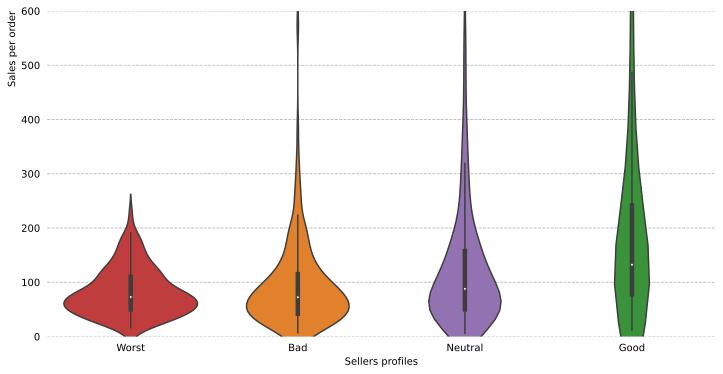

In [53]:
plt.figure(figsize=(12,6))
feature = 'sales_per_order'
ax = sns.violinplot(
    y=feature,
    x='profile',
    data=seg_sellers,
    order=["Worst", "Bad", 'Neutral', 'Good'],
    palette={
               'Worst': 'tab:red',
               'Bad': 'tab:orange',
               'Neutral': 'tab:purple',
               'Good': 'tab:green'
           }
)
ax.set_axisbelow(True)
ax.set_ylabel('Sales per order', loc='top')
ax.set_xlabel('Sellers profiles')
sns.despine(left=True, bottom=True)
plt.tick_params(bottom=False, left=False)
ax.grid(axis='y', ls='--')
ax.set(ylim=(0, 600));

## Customers happiness

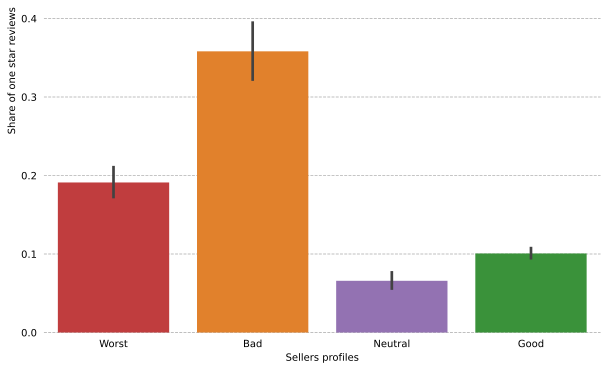

In [54]:
plt.figure(figsize=(10,6))
feature = 'share_of_one_stars'
ax = sns.barplot(
    y=feature,
    x='profile',
    data=seg_sellers,
    order=["Worst", "Bad", 'Neutral', 'Good'],
    palette={
               'Worst': 'tab:red',
               'Bad': 'tab:orange',
               'Neutral': 'tab:purple',
               'Good': 'tab:green'
           }
)
ax.set_axisbelow(True)
ax.set_yticks([0, 0.10, 0.20, 0.30, 0.40])
ax.set_ylabel('Share of one star reviews', loc='top')
sns.despine(left=True, bottom=True)
plt.tick_params(bottom=False, left=False)
ax.grid(axis='y', ls='--')
ax.set_xlabel('Sellers profiles');

# Bad users prevention

<img src='https://media.focus-cinema.com/i/847/8470298/matrix-reloaded-L-9z6sl5.jpeg' width=660 />

## Behaviour pattern

In [43]:
fig = px.scatter(
    x='share_of_one_stars', y='sales_per_order',
    size_max=20, size='sales',
    color= 'profits',
    width=950, height=600,
    data_frame=sellers,
    labels={
        'share_of_one_stars': 'Share of one star (%)',
        'sales_per_order': 'Sales per order',
        'sales': 'Sales',
        'profits': 'Profits'
    }
)
fig.update_layout(
    {'plot_bgcolor': 'rgba(0,0,0,0)'},
    yaxis_range=[0,500],
    xaxis_range=[0, 0.3],
    )
fig.update_xaxes(title='Share of one star reviews (in %)')
fig.update_yaxes(title='Sales per order')
fig.show()

## Behaviour pattern

- Share of one star > 10%

- Waiting time > 12 days

- Sales per order < 200



**Action : Temporaly ban these sellers, then enroll them in an olist training**


## Location pattern

Create a dataframe of sellers / city

In [44]:
features_to_avg = [
    'seller_city',
    'delay_to_carrier',
    'wait_time',
    'active_months',
    'review_score',
]
features_to_sum = [
    'seller_city',
    'profits',
    'sales'
]
sellers_city = np.round(sellers[features_to_avg]\
                        .groupby('seller_city', as_index=False)\
                        .mean(), 1)
sellers_city = np.round(sellers_city.merge(
        sellers[features_to_sum].groupby('seller_city', as_index=False).sum(),
        on='seller_city'
        ),0).merge(
        sellers[['seller_city','seller_id']].groupby('seller_city', as_index=False).count(),
        on='seller_city'
        ).merge(
        round(sellers[['seller_city', 'geolocation_lat', 'geolocation_lng']], 2),
        on='seller_city'
)
sellers_city.columns = [
    'seller_city',
    'avg_delay_to_carrier',
    'avg_wait_time',
    'avg_active_months',
    'avg_review_score',
    'total_profits',
    'total_sales',
    'n_sellers',
    'lat',
    'lng'
]
sellers_city.dropna(inplace=True)
sellers_city.drop_duplicates(inplace=True)

In [45]:
lat_foc = -21.77
lon_foc = -48.83
fig = px.scatter_geo(
    sellers_city,
    lat='lat', lon='lng',
    hover_name='seller_city',
    hover_data=sellers_city.columns,
    size="total_sales", size_max=70,
    color='total_profits',
    scope='south america', title='Repartition of sellers',
    center=dict(lat=lat_foc, lon=lon_foc),
    width=700, height=700,
    labels={
        'total_profits': 'Total profits',
        'seller_city': 'City',
        'total_sales': 'Total sales',
        'avg_delay_to_carrier': 'Average delay to carrier',
        'avg_wait_time': 'Average waiting time',
        'avg_active_months': 'Average activity period (in months)',
        'avg_review_score': 'Average review score',
        'n_sellers': 'Number of sellers',
        'lat': 'Latitude',
        'lng': 'Longitude'
    }
)
fig.update_geos(fitbounds="locations")
fig.update_layout(
    geo = dict(
        center=dict(lat=lat_foc, lon=lon_foc), # this will center on the point
    )
)
fig.show()